In [1]:
%matplotlib inline
from __future__ import division

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from itertools import product
from os.path import join
from biom import load_table

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context("poster")

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

In [2]:
# Mathematica's default color list
colors = [(0.368417,0.506779,0.709798),
          (0.880722,0.611041,0.142051),
          (0.560181,0.691569,0.194885),
          (0.922526,0.385626,0.209179),
          (0.528488,0.470624,0.701351),
          (0.772079,0.431554,0.102387),
          (0.363898,0.618501,0.782349),
          (1,0.75,0),
          (0.647624,0.37816,0.614037),
          (0.571589,0.586483,0.),
          (0.915,0.3325,0.2125),
          (0.400822,0.522007,0.85),
          (0.972829,0.621644,0.073362),
          (0.736783,0.358,0.503027),
          (0.280264,0.715,0.429209)]
sns.set_palette(colors)

# Temporal Dynamics

In [3]:
from collections import defaultdict

import pandas as pd

def distances_and_labels_from_data(dm, df, patient_category='PATIENT_NUMBER',
                                   timepoint_category='TIMEPOINT_NUMBER',
                                   interest_category='IBD_TYPE'):
    """Return a list of lists of distances and the corresponding labels"""

    diff_ibd = defaultdict(list)

    output = pd.Series(index=df.index)
    
    for patient in df[patient_category].unique():
        # create a patient data frame
        patient_df = df[df[patient_category] == patient]

        # retrieve the sorted list of sample idenifiers
        sorted_ids = patient_df.sort(timepoint_category).index.tolist()

        # we are assuming all have the same value as
        # patients shouldn't change their IBD_TYPE
        ibd_type = patient_df[interest_category][0]

        # we go to len - 1 to account for the fact that
        # the first difference returns a series of N-1 length 
        for idx in range(len(sorted_ids)-1):
            a = patient_df.loc[sorted_ids[idx]][timepoint_category]
            b = patient_df.loc[sorted_ids[idx+1]][timepoint_category]
            # only day-to-day distances
            if (b-a) != 1:
                continue
                
            # get the distance between the timepoints from the distance matrix
            the_distance = dm[sorted_ids[idx], sorted_ids[idx+1]]
            diff_ibd[ibd_type].append(the_distance)
            output.loc[sorted_ids[idx]] = the_distance

    # defaultdicts are the devil cast to a regular dict
    diff_ibd = dict(diff_ibd)
    
    # put this into a format boxplots can understand
    dists, labels = [], []
    for k, v in diff_ibd.iteritems():
        labels.append(k)
        dists.append(np.asarray(v))
    
    return dists, labels, output

def format_latex(n):
    """Format a number ready for scientific notation in latex"""
    
    if n > 0.01:
        return str(n)
    
    val = r'%e' % n
    val = val.replace('e', r'x10^{')+'}'
    return val

The rare OTUs seem to be driving the differences between patients that underwent surgery and those who didn't

In [4]:
mf = load_mf("metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt")

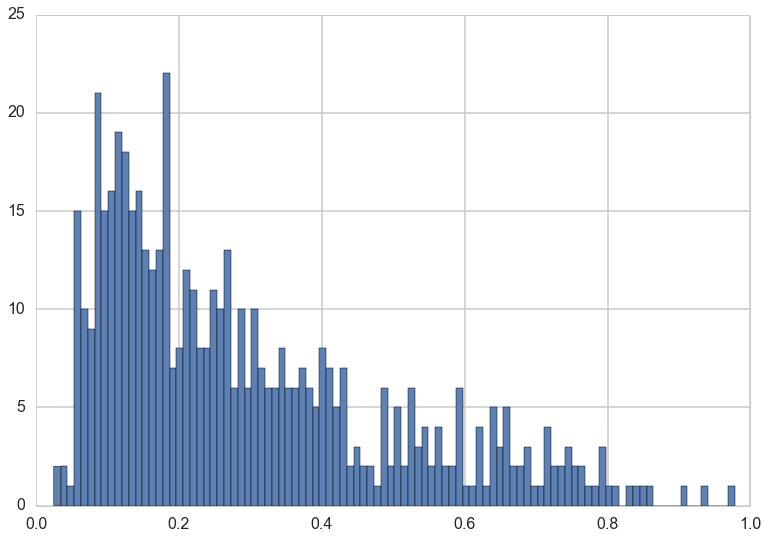

In [5]:
mf['Weighted UniFrac timepoint distance'].astype(float).hist(bins=100)

In [6]:
mf[mf['Weighted UniFrac timepoint distance'].astype(float) > 0.75]['SURGERY_AND_IBD'].value_counts()

Crohns              7
Controls            6
Crohns (surgery)    4
dtype: int64

In [11]:
!mkdir -p analysis/group-significance/

# filter out OTUs that are not present in at least 10% of the samples
# note that we have 732 samples so, 73 samples it is
!filter_otus_from_otu_table.py -i data-form-antonio/13_8_trim/otu_table.ids.nocontaminants.noblanks.biom \
-o analysis/group-significance/otu_table.group-significance.biom \
-s 73

!group_significance.py -i analysis/group-significance/otu_table.group-significance.biom \
-m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt \
-o analysis/group-significance/SURGERY_AND_IBD.tsv -s kruskal_wallis -c SURGERY_AND_IBD

!group_significance.py -i analysis/group-significance/otu_table.group-significance.biom \
-m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt \
-o analysis/group-significance/IBD.tsv -s kruskal_wallis -c IBD

# Trying the same thing out but summarized at the genus level

In [19]:
# Relative abundances
!mkdir -p analysis/group-significance/taxonomic-summaries-relative/
!summarize_taxa.py -i analysis/group-significance/otu_table.group-significance.biom \
-o analysis/group-significance/taxonomic-summaries-relative/ \
-m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt

In [10]:
!summarize_taxa.py -i analysis/group-significance/otu_table.group-significance.biom \
-o analysis/group-significance/taxonomic-summaries \
-a -m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt

!group_significance.py -i analysis/group-significance/taxonomic-summaries/otu_table.group-significance_L6.biom \
-m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt \
-o analysis/group-significance/SURGERY_AND_IBD.L6.tsv -s kruskal_wallis -c SURGERY_AND_IBD

!group_significance.py -i analysis/group-significance/taxonomic-summaries/otu_table.group-significance_L6.biom \
-m metadata-2/mapping_file.fixed.alpha.cleaned.cleaned.distances.txt \
-o analysis/group-significance/IBD.L6.tsv -s kruskal_wallis -c IBD

Metadata format could not be determined or metadata key (taxonomy) was incorrect. Metadata will not be returned.
Metadata format could not be determined or metadata key (taxonomy) was incorrect. Metadata will not be returned.


Separate by quantiles the variability and check what are the OTUs that differentiate the groups!!

In [62]:
!head -n 1 analysis/slearning-even/slearning-commands.sh

single_rarefaction.py -i otu_table.filtered.atleast7400.biom -d 7400 -o otu_table.filtered.even7400.1-3-1.biom; filter_samples_from_otu_table.py -i otu_table.filtered.even7400.1-3-1.biom -o otu_table.filtered.even7400.subset.1-3-1.biom --sample_id_fp ids_1_3_1.txt; supervised_learning.py -i otu_table.filtered.even7400.subset.1-3-1.biom -m mapping_file.fixed.alpha.cleaned.txt -c IBD -o cv-10-IBD-1-3-1 -e cv10;


# Summarizing everything in a single dataframe (**RELATIVE** abundance)

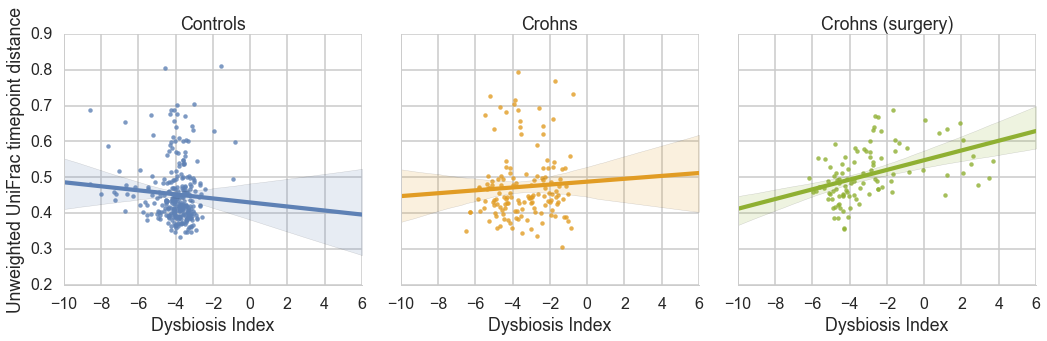

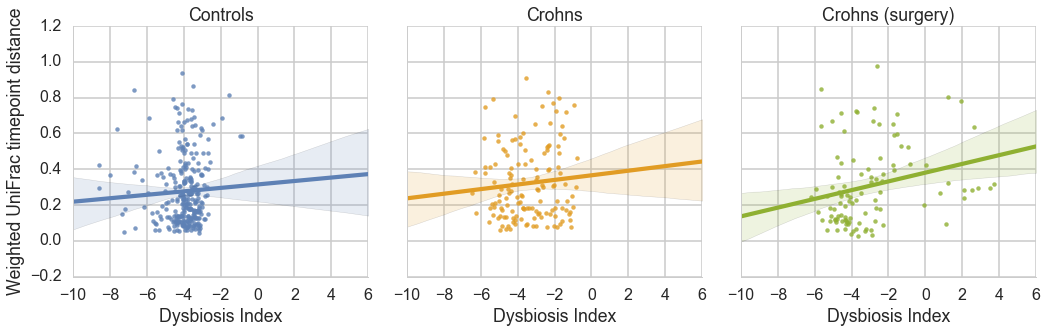

In [7]:
!mkdir -p analysis/beta/regressions/
path = 'analysis/beta/regressions/'

mf = load_mf('analysis/group-significance/taxonomic-summaries-relative/mapping_file.fixed.alpha.cleaned.cleaned.distances_L6.txt')

# according to figure 2 in the Gevers paper
prot = {'__Dialister', '__Bilophila', '__Oscillospira', '__Faecalibacterium', '__Ruminococcaceae', '__Dorea',
        '__Erysipelotrichaceae', '__Ruminococcus', '__Coprococcus', '__Lachnospiraceae', '__Bacteroides',
        '__Parabacteroides', '__Rikenellaceae', '__Sutterella'}
infl = {'__Fusobacterium', '__Haemophilus', '__Veillonella', '__Escherichia'}

mf['Protective'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
mf['Inflammatory'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
for column_name in mf.columns:
    if any([True for p in prot if p in column_name]):
        mf['Protective'] += mf[column_name].astype(np.float)
    elif any([True for i in infl if i in column_name]):
        mf['Inflammatory'] += mf[column_name].astype(np.float)
    else:
        continue

mf['Unweighted UniFrac timepoint distance'] = mf['Unweighted UniFrac timepoint distance'].astype(np.float)
mf['Weighted UniFrac timepoint distance'] = mf['Weighted UniFrac timepoint distance'].astype(np.float)

mf['SURGERY'].replace({'NA': 'No'}, inplace=True)

# calculating the dysbiosis index
mf['Dysbiosis Index'] = np.divide(mf['Inflammatory'], mf['Protective']).astype(np.float)
# drop any samples with undefined values
mf['Dysbiosis Index'].replace({0: np.nan}, inplace=True)
mf['Dysbiosis Index'] = np.log(mf['Dysbiosis Index'])

rep = {'IBD': {'Crohns': "CD", "Healthy Controls": 'Controls'}}
g = sns.lmplot('Dysbiosis Index', 'Unweighted UniFrac timepoint distance', data=mf.replace(rep),
               col='SURGERY_AND_IBD', hue='SURGERY_AND_IBD')
g.set_titles('{col_name}')
g.savefig('analysis/beta/regressions/unweighted-unifrac.pdf')
g = sns.lmplot('Dysbiosis Index', 'Weighted UniFrac timepoint distance', data=mf.replace(rep),
               col='SURGERY_AND_IBD', hue='SURGERY_AND_IBD')
g.set_titles('{col_name}')
g.savefig('analysis/beta/regressions/weighted-unifrac.pdf')

In [8]:
mf.SURGERY_AND_IBD.value_counts()

Controls            374
Crohns              211
Crohns (surgery)    147
Name: SURGERY_AND_IBD, dtype: int64

In [9]:
from scipy.stats import pearsonr

for c in mf['SURGERY_AND_IBD'].unique():
    x = mf[mf['SURGERY_AND_IBD'] == c].copy()
    x.dropna(inplace=True)

    print '%s' % (c)
    r, p = pearsonr(x['Dysbiosis Index'], x['Weighted UniFrac timepoint distance'])
    print '\tDysbiosis Index vs delta Weighted UniFrac: r=%f p=%f' % (r, p)
    r, p = pearsonr(x['Dysbiosis Index'], x['Unweighted UniFrac timepoint distance'])
    print '\tDysbiosis Index vs delta Unweighted UniFrac: r=%f p=%f' % (r, p)

del x

Controls
	Dysbiosis Index vs delta Weighted UniFrac: r=0.050969 p=0.387160
	Dysbiosis Index vs delta Unweighted UniFrac: r=-0.068985 p=0.241562
Crohns
	Dysbiosis Index vs delta Weighted UniFrac: r=0.088753 p=0.295300
	Dysbiosis Index vs delta Unweighted UniFrac: r=0.059281 p=0.485005
Crohns (surgery)
	Dysbiosis Index vs delta Weighted UniFrac: r=0.250669 p=0.011049
	Dysbiosis Index vs delta Unweighted UniFrac: r=0.429102 p=0.000007


In [9]:
pearsonr?